# LATE推定

## セッティング
- ECサイトにて、とある施策が実施されていたとする
  - そのキャンペーンの効果検証をしたいが、施策対象者はランダムに割り当てられておらず、効果検証が難しい
- そこで、施策の訴求方法を工夫することで効果検証が可能かどうかの検証を行う
  - 施策の訴求方法の工夫: 訴求方法を2種類用意し、どちらの方法で訴求されるかはユーザーごとにランダムで割り当てる
    - Treatment: 画面Aと画面Bの両方で訴求が行われる
    - Contorl  : 画面Aのみで訴求が行われる
- 検証の流れ
  - 訴求の工夫を行わない状態での効果検証
    - 効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）
    - 効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)
  - 訴求の工夫を行った状態での効果検証
    - 効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）
    - 効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)
    - 効果検証③: 施策訴求方法に工夫ありきの状態でLATE推定を行い、施策認知による購入への効果を推定する
  - 総括

## モジュールインポート

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm

## 関数定義

データ生成とLATE推定のコードはうとしんさんの[こちらの記事](https://qiita.com/s1ok69oo/items/d9f3a3860388f3b9911d)を参考にさせていただきました

In [2]:
def generate_plain_data(random_seed: int, data_size: int):
    '''効果検証対象となるデータを作成する(施策訴求方法に工夫なし)

    Args:
        random_seed (int): 乱数のシード値
        data_size   (int): データの行数

    Returns:
        df: 効果検証対象となるデータフレーム
            ├X1: 特徴量1（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X2: 特徴量2（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X3: 特徴量3（サイト回遊意欲・購入意欲の高さとは関係ない交絡因子でないもの）
            ├Z : バナー訴求対象（この状態では全員1）
            ├D : バナー閲覧有無
            └Y : 購入有無
    '''

    np.random.seed(random_seed)
    size = data_size
    
    # サイト回遊意欲・購入意欲の高さ: X0・X1・X2が存在し、X0は未観測とする
    X0 = np.random.uniform(0, 5, size=size)
    X1 = np.random.uniform(0, 5, size=size)
    X2 = np.random.uniform(0, 5, size=size)
    # サイト回遊意欲・購入意欲の高さとは関係ない観測可能な特徴量X3を設定する
    X3 = np.random.uniform(0, 5, size=size)
    
    # バナー訴求: 訴求の工夫を行わない = 全員画面Aのみで訴求が行われるものとする
    Z = np.array([])
    for i in range(size):
        Z_i = 1
        Z = np.append(Z, Z_i)  
    
    # 施策認知確率: サイト回遊意欲・購入意欲とバナーの影響で施策認知確率も高くなるものとする
    d_prob = (X0 + X1 + X2) / 30 + 0.1*Z + np.random.uniform(-0.01, 0.01, size=size) # バナーによる施策認知への効果: 0.1
    d_prob = np.clip(d_prob, 0, 1)
    D = np.array([])
    for i in range(size):
        D_i = np.random.choice(2, size=1, p=[1-d_prob[i], d_prob[i]])[0]
        D = np.append(D, D_i)
    
    # 購入の有無: サイト回遊意欲・購入意欲が高いほど、購入確率も高く、また施策認知により購入確率が上がるものとする
    y_prob = (X0 + X1 + X2) / 30 + np.random.uniform(-0.01, 0.01, size=size) + 0.15*D # 施策認知による購入への効果: 0.15
    y_prob = np.clip(y_prob, 0, 1)
    Y = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y = np.append(Y, Y_i)
    
    df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3, 'Z':Z, 'D':D, 'Y': Y}).astype('float')
    return df

In [3]:
def diff_Y_from_calculate_simple_difference(df: pd.DataFrame):
    '''効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）
    
    Args:
        df(pd.DataFrame): 効果検証対象となるデータフレーム

    Returns:
        diff_Y: 購入率差分

    '''
    # バナーを見た人と見ていない人
    banner_imp_df = df[df['D']==1]
    banner_no_imp_df = df[df['D']==0]
    
    # 購入有無比較
    banner_imp_Y_average = banner_imp_df['Y'].mean()
    banner_no_imp_Y_average = banner_no_imp_df['Y'].mean()
    diff_Y = banner_imp_Y_average - banner_no_imp_Y_average

    return diff_Y

In [4]:
def diff_Y_from_ps_score_matching(df: pd.DataFrame):
    '''効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)
    
    Args:
        df(pd.DataFrame): 効果検証対象となるデータフレーム

    Returns:
        diff_Y: 購入率差分

    '''
    # 傾向スコア推定モデル
    model = LogisticRegression()
    model.fit(df[['X1', 'X2', 'X3']], df['D']) # X3を交絡因子と勘違いしているという設定
    pred_pscore = model.predict_proba(df[['X1', 'X2', 'X3']])[:, 1]
    df['pred_pscore'] = pred_pscore
    # マッチング
    df_1 = df[df['D']==1]
    df_0 = df[df['D']==0]
    
    pair_df_list = []
    for row in df_1.index:
        df_1_pscore = df_1['pred_pscore'][row]
        abs_diff = abs(df_0['pred_pscore'] - df_1_pscore)
    
        nearest_index = abs_diff[abs_diff == abs_diff.min()].index
        pair_df = df_0.loc[[nearest_index[0]]]
        pair_df_list.append(pair_df)
    
    concat_pair_df = pd.concat(pair_df_list, axis=0)
    concat_pair_df.columns = ['pair_' + col for col in concat_pair_df.columns]
    
    pair_1_df = df_1.reset_index(drop=True)
    pair_0_df = concat_pair_df.reset_index(drop=True)
    pair_df = pd.concat([pair_1_df, pair_0_df], axis=1)
    
    diff_Y = (pair_df['Y'] - pair_df['pair_Y']).mean()    

    return diff_Y

In [5]:
def generate_refined_data(random_seed: int, data_size: int):
    '''効果検証対象となるデータを作成する(施策訴求方法に工夫あり)
       └施策の訴求方法の工夫: 訴求方法を2種類用意し、どちらの方法で訴求されるかはユーザーごとにランダムで割り当てる
        ├Treatment(Z=2): 画面Aと画面Bの両方で訴求が行われる
        └Contorl  (Z=1): 画面Aのみで訴求が行われる
    Args:
        random_seed (int): 乱数のシード値
        data_size   (int): データの行数

    Returns:
        df: 効果検証対象となるデータフレーム
            ├X1: 特徴量1（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X2: 特徴量2（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X3: 特徴量3（サイト回遊意欲・購入意欲の高さとは関係ない交絡因子でないもの）
            ├Z : バナー訴求対象（Treatmentは2、Controlは1）
            ├D : バナー閲覧有無
            └Y : 購入有無
    '''

    np.random.seed(random_seed)
    size = data_size
    
    # サイト回遊意欲・購入意欲の高さ: X0・X1・X2が存在し、X0は未観測とする
    X0 = np.random.uniform(0, 5, size=size)
    X1 = np.random.uniform(0, 5, size=size)
    X2 = np.random.uniform(0, 5, size=size)
    # サイト回遊意欲・購入意欲の高さとは関係ない観測可能な特徴量X3を設定する
    X3 = np.random.uniform(0, 5, size=size)
    
    # バナー訴求: ランダムで訴求2パターンが割り当てられるものとする（Treatmentは2、Controlは1）
    Z = np.array([])
    for i in range(size):
        Z_i = np.random.choice(2, size=1, p=[0.5, 0.5])[0] + 1
        Z = np.append(Z, Z_i)  
    
    # 施策認知確率: サイト回遊意欲・購入意欲とバナーの影響で施策認知確率も高くなるものとする
    d_prob = (X0 + X1 + X2) / 30 + 0.1*Z + np.random.uniform(-0.01, 0.01, size=size) # バナーによる施策認知への効果: Control:0.1、Treatment:0.2
    d_prob = np.clip(d_prob, 0, 1)
    D = np.array([])
    for i in range(size):
        D_i = np.random.choice(2, size=1, p=[1-d_prob[i], d_prob[i]])[0]
        D = np.append(D, D_i)
    
    # 購入の有無: サイト回遊意欲・購入意欲が高いほど、購入確率も高く、また施策認知により購入確率が上がるものとする
    y_prob = (X0 + X1 + X2) / 30 + np.random.uniform(-0.01, 0.01, size=size) + 0.15*D # 施策認知による購入への効果: 0.15
    y_prob = np.clip(y_prob, 0, 1)
    Y = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y = np.append(Y, Y_i)
    
    df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3, 'Z':Z, 'D':D, 'Y': Y}).astype('float')
    return df

In [6]:
def diff_Y_from_calculate_late(df: pd.DataFrame):
    '''効果検証③: 施策訴求方法に工夫ありきの状態でLATE推定を行い、施策認知による購入への効果を推定する
    
    Args:
        df(pd.DataFrame): 効果検証対象となるデータフレーム

    Returns:
        diff_Y: 購入率差分

    '''
    E_Y_Z_1 = df[df['Z']==2]['Y'].mean()
    E_Y_Z_0 = df[df['Z']==1]['Y'].mean()
    E_D_Z_1 = df[df['Z']==2]['D'].mean()
    E_D_Z_0 = df[df['Z']==1]['D'].mean()
    late = (E_Y_Z_1 - E_Y_Z_0) / (E_D_Z_1 - E_D_Z_0)
    
    diff_Y = late

    return diff_Y

In [7]:
# シミュレーション回数とデータの行数を指定する
n_trials = 300
data_size = 10000

## 訴求の工夫を行わない状態での効果検証

In [8]:
# 手法間比較のために各手法により算出した購入率差分を格納するリストを生成
avg_diff_Y_list = []
std_diff_Y_list = []

### 効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:10<00:00,  4.26it/s]


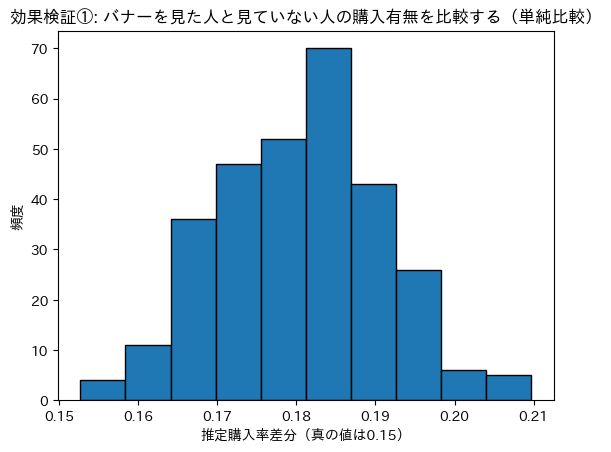

単純比較による購入率差分平均   : 0.180
単純比較による購入率差分標準偏差: 0.010


In [9]:
diff_Y_list = []
for i in tqdm(range(n_trials)):
    df = generate_plain_data(random_seed=i, data_size=data_size)
    # 単純比較による購入率差分
    diff_Y = diff_Y_from_calculate_simple_difference(df)
    diff_Y_list.append(diff_Y)

# ヒストグラムをプロット
plt.hist(diff_Y_list, bins=10, edgecolor='black')
plt.title('効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）')
plt.xlabel('推定購入率差分（真の値は0.15）')
plt.ylabel('頻度')
plt.show()
avg_diff_Y = np.array(diff_Y_list).mean()
std_diff_Y = np.array(diff_Y_list).std()
avg_diff_Y_list.append(avg_diff_Y)
std_diff_Y_list.append(std_diff_Y)
print(f'単純比較による購入率差分平均   : {avg_diff_Y:,.3f}')
print(f'単純比較による購入率差分標準偏差: {std_diff_Y:,.3f}')

### 効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:34<00:00,  1.12s/it]


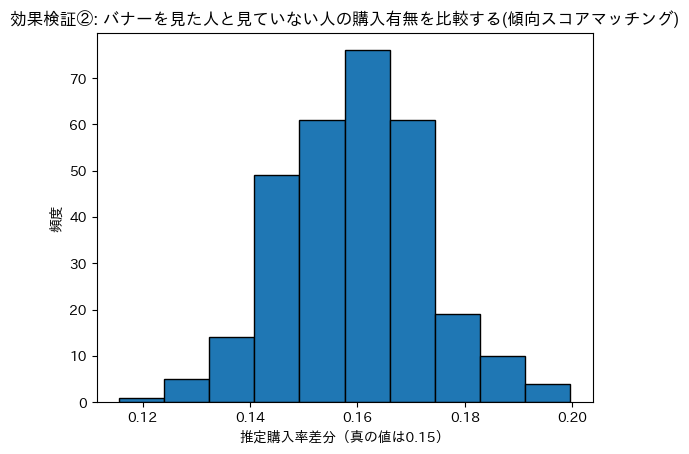

傾向スコアマッチング比較による購入率差分平均   : 0.160
傾向スコアマッチング比較による購入率差分標準偏差: 0.013


In [10]:
diff_Y_list = []
for i in tqdm(range(n_trials)):
    df = generate_plain_data(random_seed=i, data_size=data_size)
    # 傾向スコアマッチングによる購入率差分
    diff_Y = diff_Y_from_ps_score_matching(df)
    diff_Y_list.append(diff_Y)

# ヒストグラムをプロット
plt.hist(diff_Y_list, bins=10, edgecolor='black')
plt.title('効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)')
plt.xlabel('推定購入率差分（真の値は0.15）')
plt.ylabel('頻度')
plt.show()
avg_diff_Y = np.array(diff_Y_list).mean()
std_diff_Y = np.array(diff_Y_list).std()
avg_diff_Y_list.append(avg_diff_Y)
std_diff_Y_list.append(std_diff_Y)
print(f'傾向スコアマッチング比較による購入率差分平均   : {avg_diff_Y:,.3f}')
print(f'傾向スコアマッチング比較による購入率差分標準偏差: {std_diff_Y:,.3f}')

### 各効果検証手法で算出した購入率差分を比較する

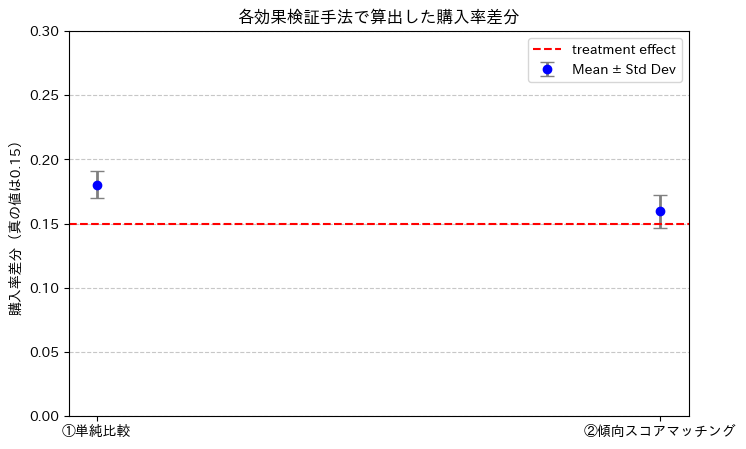

In [11]:
# 凡例を設定
categories = ['①単純比較', '②傾向スコアマッチング']

# 比較結果を描画
plt.figure(figsize=(8, 5))
# 点とエラーバーを描画
plt.errorbar(
    categories,
    avg_diff_Y_list,
    yerr=std_diff_Y_list,
    fmt='o',  # 点のマーカー
    color='blue',  # 点の色
    ecolor='gray',  # エラーバーの色
    elinewidth=2,  # エラーバーの線幅
    capsize=5,  # エラーバーの端の長さ
    label='Mean ± Std Dev'
)
plt.axhline(y=0.15, color='red', linestyle='--', label='treatment effect')
plt.title('各効果検証手法で算出した購入率差分')
plt.ylabel('購入率差分（真の値は0.15）')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 0.3)
plt.show()

## 訴求の工夫を行った状態での効果検証

In [12]:
# 手法間比較のために各手法により算出した購入率差分を格納するリストを生成
avg_diff_Y_list = []
std_diff_Y_list = []

### 効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:35<00:00,  3.14it/s]


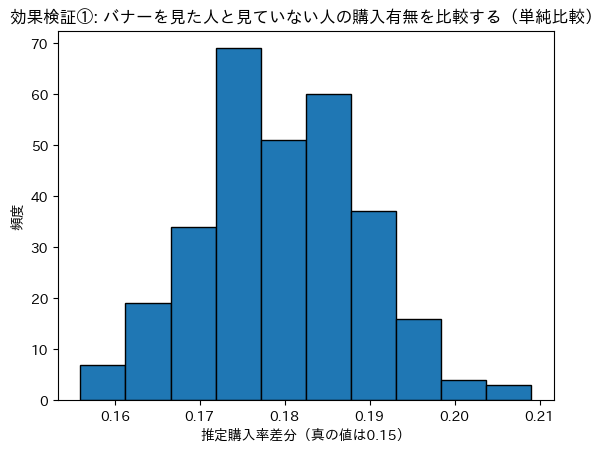

単純比較による購入率差分平均   : 0.180
単純比較による購入率差分標準偏差: 0.010


In [13]:
diff_Y_list = []
for i in tqdm(range(n_trials)):
    df = generate_refined_data(random_seed=i, data_size=data_size)
    # 単純比較による購入率差分
    diff_Y = diff_Y_from_calculate_simple_difference(df)
    diff_Y_list.append(diff_Y)

# ヒストグラムをプロット
plt.hist(diff_Y_list, bins=10, edgecolor='black')
plt.title('効果検証①: バナーを見た人と見ていない人の購入有無を比較する（単純比較）')
plt.xlabel('推定購入率差分（真の値は0.15）')
plt.ylabel('頻度')
plt.show()
avg_diff_Y = np.array(diff_Y_list).mean()
std_diff_Y = np.array(diff_Y_list).std()
avg_diff_Y_list.append(avg_diff_Y)
std_diff_Y_list.append(std_diff_Y)
print(f'単純比較による購入率差分平均   : {avg_diff_Y:,.3f}')
print(f'単純比較による購入率差分標準偏差: {std_diff_Y:,.3f}')

### 効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:32<00:00,  1.31s/it]


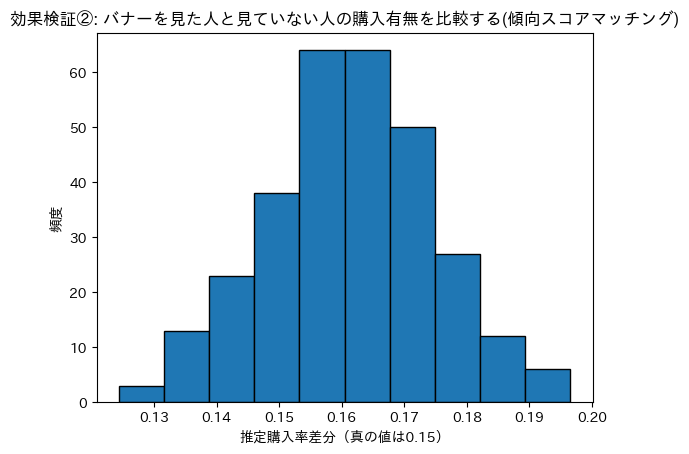

傾向スコアマッチング比較による購入率差分平均   : 0.161
傾向スコアマッチング比較による購入率差分標準偏差: 0.013


In [14]:
diff_Y_list = []
for i in tqdm(range(n_trials)):
    df = generate_refined_data(random_seed=i, data_size=data_size)
    # 傾向スコアマッチングによる購入率差分
    diff_Y = diff_Y_from_ps_score_matching(df)
    diff_Y_list.append(diff_Y)

# ヒストグラムをプロット
plt.hist(diff_Y_list, bins=10, edgecolor='black')
plt.title('効果検証②: バナーを見た人と見ていない人の購入有無を比較する(傾向スコアマッチング)')
plt.xlabel('推定購入率差分（真の値は0.15）')
plt.ylabel('頻度')
plt.show()
avg_diff_Y = np.array(diff_Y_list).mean()
std_diff_Y = np.array(diff_Y_list).std()
avg_diff_Y_list.append(avg_diff_Y)
std_diff_Y_list.append(std_diff_Y)
print(f'傾向スコアマッチング比較による購入率差分平均   : {avg_diff_Y:,.3f}')
print(f'傾向スコアマッチング比較による購入率差分標準偏差: {std_diff_Y:,.3f}')

### 効果検証③: 施策訴求方法に工夫ありきの状態でLATE推定を行い、施策認知による購入への効果を推定する

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  3.08it/s]


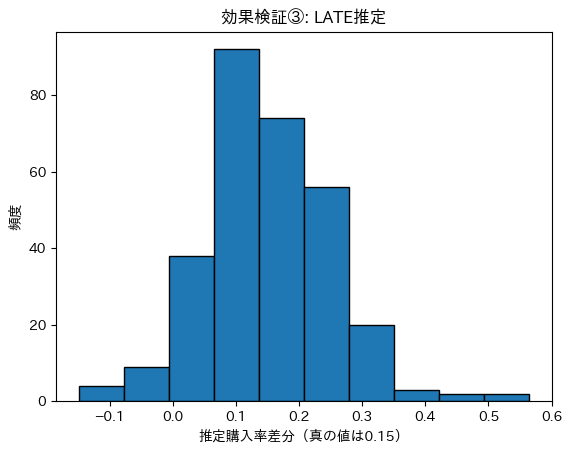

LATE推定による購入率差分平均   : 0.151
LATE推定による購入率差分標準偏差: 0.099


In [15]:
diff_Y_list = []
for i in tqdm(range(n_trials)):
    df = generate_refined_data(random_seed=i, data_size=data_size)
    # LATE推定による購入率差分
    diff_Y = diff_Y_from_calculate_late(df)
    diff_Y_list.append(diff_Y)

# ヒストグラムをプロット
plt.hist(diff_Y_list, bins=10, edgecolor='black')
plt.title('効果検証③: LATE推定')
plt.xlabel('推定購入率差分（真の値は0.15）')
plt.ylabel('頻度')
plt.show()
avg_diff_Y = np.array(diff_Y_list).mean()
std_diff_Y = np.array(diff_Y_list).std()
avg_diff_Y_list.append(avg_diff_Y)
std_diff_Y_list.append(std_diff_Y)
print(f'LATE推定による購入率差分平均   : {avg_diff_Y:,.3f}')
print(f'LATE推定による購入率差分標準偏差: {std_diff_Y:,.3f}')

### 各効果検証手法で算出した購入率差分を比較する

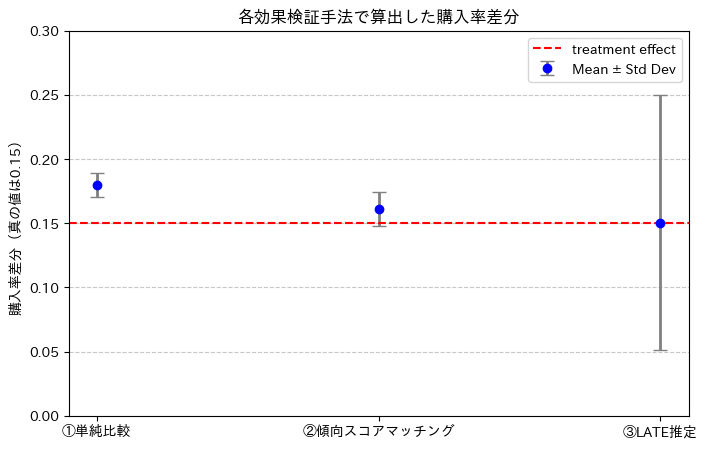

In [16]:
# 凡例を設定
categories = ['①単純比較', '②傾向スコアマッチング', '③LATE推定']

# 比較結果を描画
plt.figure(figsize=(8, 5))
# 点とエラーバーを描画
plt.errorbar(
    categories,
    avg_diff_Y_list,
    yerr=std_diff_Y_list,
    fmt='o',  # 点のマーカー
    color='blue',  # 点の色
    ecolor='gray',  # エラーバーの色
    elinewidth=2,  # エラーバーの線幅
    capsize=5,  # エラーバーの端の長さ
    label='Mean ± Std Dev'
)
plt.axhline(y=0.15, color='red', linestyle='--', label='treatment effect')
plt.title('各効果検証手法で算出した購入率差分')
plt.ylabel('購入率差分（真の値は0.15）')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 0.3)
plt.show()

## 総括

#### 訴求の工夫を行わない状態
| 効果検証手法 | バイアス | バリアンス |
|---------|:---------:|:---------:|
| ①単純比較 | × | ○ |
| ②傾向スコアマッチング | △ | △ |

#### 訴求の工夫を行った状態
| 効果検証手法 | バイアス | バリアンス |
|---------|:---------:|:---------:|
| ①単純比較 | × | ○ |
| ②傾向スコアマッチング | △ | △ |
| ③LATE推定 | ○ | × |